# RNN

## Data

Load back the dataframe that's been pre-processed at last stage.

In [1]:
import pandas as pd
import nltk

def custom_tokenize(text):
    text = ''.join([ch for ch in text if not ch.isdigit() and 
                    ch not in ['@', '#', ':', '.', ',', ';', '$', '%', '&', '\'',
                               '-', '(', ')', '-', '[', ']', '“', '”', '\'\'', '+',
                               '/', '``', '|', '—']])
    tokens = nltk.word_tokenize(text)
    return tokens

## load a pickle file back
df_words = pd.read_pickle("./df/df_words.pkl")

In [2]:
df_words[::5000]

,label,position,sentence,categories,sent_len
0,BACKGROUND,0,Rapid popularity of Internet of Things (IoT) a...,cs.CR/cs.AI/q-bio.NC,29
5000,BACKGROUND,4,Previous methods typically match the whole sou...,cs.CV,32
10000,BACKGROUND,5,"Thus, no positioning service can be obtained i...",cs.NI,10
15000,OBJECTIVES,0,The ultimate goal of any software developer se...,cs.SE,18
20000,OBJECTIVES,1,The proposed framework is aiming to address tw...,cs.CV,15
25000,METHODS,4,Logical and behavioral equivalence of game mod...,cs.LO,9
30000,METHODS,6,Components of the NiftyNet pipeline including ...,cs.CV/cs.LG/cs.NE,33
35000,METHODS,4,The deferred write approach is followed to imp...,cs.DC,10
40000,RESULTS,0,"In this paper, we provide upper and lower boun...",math.PR/cs.IT/math.IT/math.OC,22
45000,RESULTS,3,We show that the information distance is a uni...,cs.IT/math.IT/math.PR/physics.data-an,12


### Split training and validating set : 80-20

In [3]:
X = df_words.drop(['label'], axis=1)
y = df_words['label']

In [4]:
from sklearn.model_selection import train_test_split

#80% train 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
X_train.head()

,position,sentence,categories,sent_len
15719,3,To properly evolve ANNs with more than one hid...,cs.NE/cs.AI,27
28652,2,Although the two senders transmit their own me...,cs.IT/math.IT,32
49339,4,Simulations on the robotic system verified our...,cs.RO,28
4730,1,"In this framework, instead of producing a fina...",cs.DS,39
8406,1,It has been observed that the set of all sound...,cs.LO,34


In [7]:
y_train.head()

15719     OBJECTIVES
28652        METHODS
49339    CONCLUSIONS
4730      BACKGROUND
8406      BACKGROUND
Name: label, dtype: object

In [8]:
X_train.to_pickle("./df/X_train.pkl") # training record
X_test.to_pickle("./df/X_test.pkl") 
y_train.to_pickle("./df/y_train.pkl") # training label
y_test.to_pickle("./df/y_test.pkl")

In [1]:
import pandas as pd
X_train = pd.read_pickle("./df/X_train.pkl")
X_test  = pd.read_pickle("./df/X_test.pkl") 
y_train = pd.read_pickle("./df/y_train.pkl")
y_test  = pd.read_pickle("./df/y_test.pkl")

## Train with word features

### convert text to sequence 

In [2]:
%%time
from keras.preprocessing.text import Tokenizer

# keras tokenizer
tokenizer = Tokenizer(num_words=20000,
                      filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',
                      lower=True)

tokenizer.fit_on_texts(X_train['sentence'].values)

# unique word/token as a dictionary {'word': index}
word_index = tokenizer.word_index

len(word_index)

Using TensorFlow backend.


CPU times: user 2.07 s, sys: 359 ms, total: 2.43 s
Wall time: 3.21 s


25999

In [3]:
word_index

{'the': 1,
 'of': 2,
 'and': 3,
 'a': 4,
 'to': 5,
 'in': 6,
 'we': 7,
 'is': 8,
 'for': 9,
 'that': 10,
 'on': 11,
 'this': 12,
 'with': 13,
 'are': 14,
 'as': 15,
 'by': 16,
 'an': 17,
 'our': 18,
 'data': 19,
 'can': 20,
 'from': 21,
 'be': 22,
 'which': 23,
 'based': 24,
 'paper': 25,
 'model': 26,
 'network': 27,
 'it': 28,
 'using': 29,
 'learning': 30,
 'results': 31,
 'show': 32,
 'proposed': 33,
 'problem': 34,
 'time': 35,
 'such': 36,
 'or': 37,
 'method': 38,
 'performance': 39,
 'algorithm': 40,
 'approach': 41,
 'these': 42,
 'have': 43,
 'also': 44,
 'networks': 45,
 'system': 46,
 'information': 47,
 'two': 48,
 'at': 49,
 'propose': 50,
 'has': 51,
 'methods': 52,
 'not': 53,
 'models': 54,
 'different': 55,
 'used': 56,
 'new': 57,
 'state': 58,
 'their': 59,
 'more': 60,
 'between': 61,
 'its': 62,
 'use': 63,
 'one': 64,
 'systems': 65,
 'image': 66,
 'algorithms': 67,
 'analysis': 68,
 'both': 69,
 'neural': 70,
 'present': 71,
 'been': 72,
 'number': 73,
 'over': 

In [10]:
max(X_train['sent_len'])

181

In [5]:
%%time

from keras.preprocessing.sequence import pad_sequences

# convert sentence to numeric sequence
X_train_seq = tokenizer.texts_to_sequences(X_train['sentence'].values)

# make every sequence equal size with padding
X_train_seq = pad_sequences(X_train_seq, maxlen=181) # max_len in sentence in training records

X_train_seq.shape # a vector of 181 elements (a vector for each sentence)

CPU times: user 1.05 s, sys: 19.4 ms, total: 1.07 s
Wall time: 1.07 s


(43458, 181)

In [6]:
y_train_series = pd.get_dummies(y_train).values
y_train_series.shape # 6 categories (as one-hot label)

(43458, 6)

In [7]:
y_train_series

array([[0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0]], dtype=uint8)

In [14]:
## prepare for evaluation data as well

X_test_seq = tokenizer.texts_to_sequences(X_test['sentence'].values)
X_test_seq = pad_sequences(X_test_seq, maxlen=181) 

y_test_series = pd.get_dummies(y_test).values

print(X_test_seq.shape) # 10865 sentence with 181 terms sequence (pad if less than 181)
y_test_series.shape    # 10865 sentence with 6 label sequence (one-hot format)

(10865, 181)


(10865, 6)

### word vector (use glove 6B 100d)

In [3]:
import numpy as np

# dictionary : {word: vector}
embeddings_index = dict()
with open('./glove.6B/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split() # a word and a bunch of vector elements
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs


len(embeddings_index) # num of word vectors

400000

In [11]:
embeddings_index['the']

array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526  ,  0.071624,  0.70565 ,  0.49744 , 

In [4]:
# embedding dimension 100
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    # if word not in embeddings_index, the value will be all zeros
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [13]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       [-0.1529    , -0.24279   ,  0.89837003, ..., -0.59100002,
         1.00390005,  0.20664001],
       ...,
       [ 0.12661999, -0.3845    , -0.82560003, ...,  0.76368999,
         0.61236   ,  0.34316   ],
       [-0.19689   , -0.54955   , -0.28466001, ..., -0.18875   ,
        -0.43698001,  0.14554   ],
       [ 0.16864   ,  0.18495999, -0.53688997, ...,  0.20904   ,
         0.19298001,  0.063896  ]])

### RNN model

In [15]:
%%time

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.callbacks import EarlyStopping

# a linear stack of layers
seq_model = Sequential()
# embedding layer : 26000 words (max), 
# 100 dimension of embedding (dim of each word vector), 
# input len 181
seq_model.add(Embedding(26000, 100, weights=[embedding_matrix],
                        input_length=X_train_seq.shape[1],
                        trainable=False)) # don't train the embedding layer (use embedding_matrix)

# LSTM layer
seq_model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))

# regular densely-connected NN layer, use softmax as activation function (loss function)
# 6 labels
seq_model.add(Dense(6, activation='softmax'))

# categorical_crossentropy for multi-label classification 
seq_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

epochs = 15
batch_size = 32

history = seq_model.fit(X_train_seq, y_train_series, 
                        epochs=epochs, batch_size=batch_size,
                        validation_data=(X_test_seq, y_test_series), 
                        # stop training when a monitored quantity has stopped improving (change lesser than 0.0001) after 3 epochs
                        callbacks=[EarlyStopping(monitor='val_loss', 
                                                 patience=3, min_delta=0.0001)])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 43458 samples, validate on 10865 samples
Epoch 1/15
43458/43458 [==============================] - 174s 4ms/step - loss: 1.4187 - acc: 0.4239 - val_loss: 1.3011 - val_acc: 0.4990
Epoch 2/15
43458/43458 [==============================] - 163s 4ms/step - loss: 1.2636 - acc: 0.5098 - val_loss: 1.2275 - val_acc: 0.5335
Epoch 3/15
43458/43458 [==============================] - 163s 4ms/step - loss: 1.2122 - acc: 0.5315 - val_loss: 1.1870 - val_acc: 0.5453
Epoch 4/15
43458/43458 [==============================] - 167s 4ms/step - loss: 1.1787 - acc: 0.5476 - val_loss: 1.1660 - val_acc: 0.5591
Epoch 5/15
43458/43458 [==============================] - 163s 4ms/step - loss: 1.1531 - acc: 0.5583 - val_loss: 1.1630 - val_acc: 0.5614
Epoch 6/15
43458/43458 [==========================

In [16]:
import pickle

# save model & history
seq_model.save('./model/rnn_glove.h5')   
pickle.dump(history, open("./model/rnn_glove_history.pkl", "wb"))

## Evaluate on Validation Set

In [17]:
# accuracy evaluation : Loss & Accuracy
seq_model.evaluate(X_test_seq,y_test_series)

10865/10865 [==============================] - 8s 760us/step


[1.1632621937614402, 0.5612517257686919]

In [18]:
%%time
pred_result = seq_model.predict(X_test_seq)

CPU times: user 18.5 s, sys: 3.21 s, total: 21.7 s
Wall time: 7.61 s


In [58]:
label_lookup = dict()
for s, label in zip(y_train_series, y_train):
    if np.argmax(s) not in label_lookup:
        label_lookup.update({np.argmax(s):label})

label_lookup

{3: 'OBJECTIVES',
 2: 'METHODS',
 1: 'CONCLUSIONS',
 0: 'BACKGROUND',
 5: 'RESULTS',
 4: 'OTHERS'}

In [25]:
with open('label_lookup.pkl', 'wb') as f:
    pickle.dump(label_lookup, f)

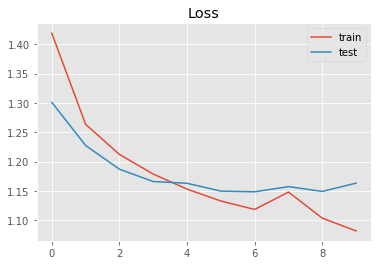

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

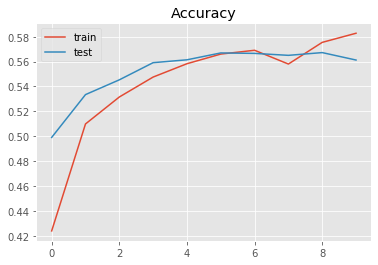

In [22]:
# turning point around 5th iteration
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

In [23]:
# low score on 'OTHERS' due to lack of support

def get_labels(seq):
    return [label_lookup[np.argmax(s)] for s in seq]

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

y_pred = get_labels(pred_result)

print(accuracy_score(y_test, y_pred))
print(classification_report(y_true=y_test, y_pred=y_pred))

0.5612517257248044
              precision    recall  f1-score   support

  BACKGROUND       0.65      0.79      0.71      2718
 CONCLUSIONS       0.40      0.16      0.23      1044
     METHODS       0.55      0.59      0.57      2759
  OBJECTIVES       0.46      0.49      0.48      1799
      OTHERS       0.38      0.17      0.23       192
     RESULTS       0.57      0.52      0.54      2353

    accuracy                           0.56     10865
   macro avg       0.50      0.45      0.46     10865
weighted avg       0.55      0.56      0.55     10865



In [30]:
list(label_lookup.values())

['OBJECTIVES', 'METHODS', 'CONCLUSIONS', 'BACKGROUND', 'RESULTS', 'OTHERS']

In [26]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=y_test, y_pred=y_pred) 

In [46]:
### from lab2 ###

# Funciton for visualizing confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix',
                          cmap=sns.cubehelix_palette(as_cmap=True)):
    """
    This function is modified from: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    classes.sort()
    #tick_marks = np.arange(len(classes))    
    
    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels = classes,
           yticklabels = classes,
           title = title,
           xlabel = 'True label',
           ylabel = 'Predicted label')

    fmt = 'd' # discrete
    padding = 0.5
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    ylim_top = len(classes) - padding
    plt.ylim([ylim_top, - padding])
    plt.tight_layout()
    plt.show()

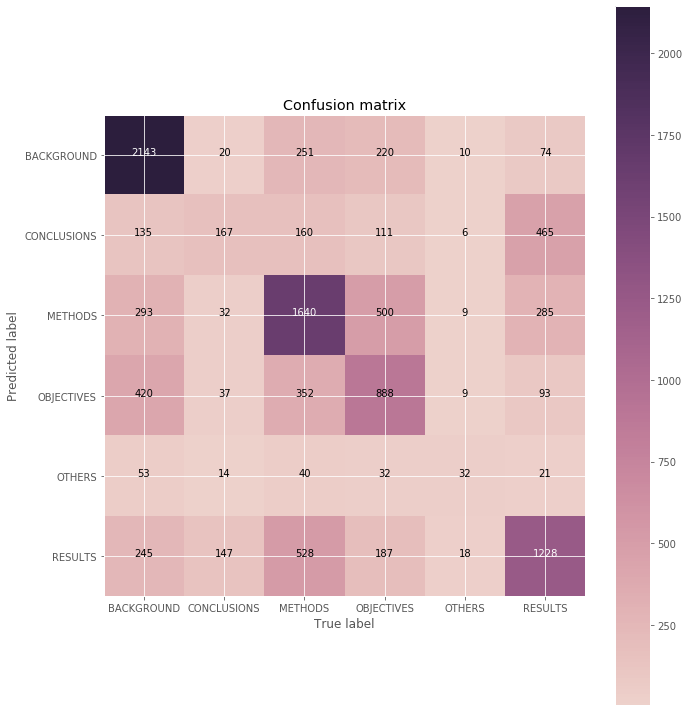

In [47]:
plot_confusion_matrix(cm, classes=list(label_lookup.values()), title='Confusion matrix')

## Consider other features

want something like

    word_feature
        |
        |
        |
        v
      embedding
        |
        |
        v
       LSTM        other_feature
         \             /
          \           /
           \         /
            \       /
             \     /
              \   /
              merge
                |
                |
                v
               dense
                |
                |
                v
               ...

### word feature input

In [9]:
X_train_seq

array([[   0,    0,    0, ...,    6,  252,  653],
       [   0,    0,    0, ...,  133,  341,  220],
       [   0,    0,    0, ..., 2824, 3369,   46],
       ...,
       [   0,    0,    0, ...,   11, 9858,  476],
       [   0,    0,    0, ...,    6,  189,  449],
       [   0,    0,    0, ...,  199, 1243, 3243]], dtype=int32)

In [10]:
X_train_seq.shape

(43458, 181)

### other features

It is very possible for the position of the sentence in the abstract and the length of sentence to be somewhat important regarding the type of the sentence. And they're numeric values.

In [19]:
X_train[['position', 'sent_len']][::10000]

,position,sent_len
15719,3,27
16546,5,38
1665,2,34
15919,2,24
18058,3,29


In [20]:
X_train[['position', 'sent_len']].values

array([[ 3, 27],
       [ 2, 32],
       [ 4, 28],
       ...,
       [ 6, 16],
       [ 0, 14],
       [ 2, 27]])

In [8]:
X_train_other = X_train[['position', 'sent_len']].values
X_test_other =   X_test[['position', 'sent_len']].values

### layers

In [10]:
from keras.layers import Input, Embedding

# the usual word feature
word_input = Input(shape=(181,), dtype='int32', name='word_input')

# encode input into 100d
x_embedding = Embedding(26000, 100, weights=[embedding_matrix],
                        input_length=X_train_seq.shape[1],
                        trainable=False)(word_input)

In [30]:
from keras.layers import LSTM, Dense, concatenate

# vector seq -> vector
lstm_out = LSTM(32)(x_embedding)

# loss for additional feature, use same label (6 types of sentence)
other_out = Dense(6, activation='sigmoid', name='other_out')(lstm_out)

other_in = Input(shape=(2,), name='other_in')
x = concatenate([lstm_out, other_in])

# output
word_out = Dense(6, activation='softmax', name='word_out')(x)

### Model

In [31]:
from keras.models import Model

model = Model(inputs=[word_input, other_in], outputs=[word_out, other_out])

model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [32]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
word_input (InputLayer)         (None, 181)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 181, 100)     2600000     word_input[0][0]                 
__________________________________________________________________________________________________
lstm_7 (LSTM)                   (None, 32)           17024       embedding_1[0][0]                
__________________________________________________________________________________________________
other_in (InputLayer)           (None, 2)            0                                            
__________________________________________________________________________________________________
concatenat

### training

In [43]:
%%time

from keras.callbacks import EarlyStopping

epochs = 15
batch_size = 32


history = model.fit({'word_input': X_train_seq, 'other_in': X_train_other},
                    {'word_out': y_train_series, 'other_out': y_train_series},
                    validation_data= ({'word_input': X_test_seq, 'other_in': X_test_other},
                                      {'word_out': y_test_series, 'other_out': y_test_series}),
                    epochs=epochs, batch_size=batch_size,
                    callbacks=[EarlyStopping(monitor='val_word_out_loss', 
                                             patience=3, min_delta=0.0001)])


Train on 43458 samples, validate on 10865 samples
Epoch 1/15
43458/43458 [==============================] - 121s 3ms/step - loss: 2.2015 - word_out_loss: 1.0583 - other_out_loss: 1.1432 - word_out_acc: 0.5915 - other_out_acc: 0.5612 - val_loss: 2.2718 - val_word_out_loss: 1.0888 - val_other_out_loss: 1.1830 - val_word_out_acc: 0.5742 - val_other_out_acc: 0.5474
Epoch 2/15
43458/43458 [==============================] - 118s 3ms/step - loss: 2.1712 - word_out_loss: 1.0443 - other_out_loss: 1.1269 - word_out_acc: 0.5975 - other_out_acc: 0.5701 - val_loss: 2.2645 - val_word_out_loss: 1.0842 - val_other_out_loss: 1.1803 - val_word_out_acc: 0.5800 - val_other_out_acc: 0.5515
Epoch 3/15
43458/43458 [==============================] - 118s 3ms/step - loss: 2.1421 - word_out_loss: 1.0321 - other_out_loss: 1.1100 - word_out_acc: 0.6038 - other_out_acc: 0.5769 - val_loss: 2.3100 - val_word_out_loss: 1.1048 - val_other_out_loss: 1.2052 - val_word_out_acc: 0.5698 - val_other_out_acc: 0.5324
Epoch 4/

---

## Evaluate on Validation Set

In [2]:
from keras.models import load_model
model = load_model('./model/rnn_glove_additional.h5')







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [4]:
import pandas as pd
X_train = pd.read_pickle("./df/X_train.pkl")
X_test  = pd.read_pickle("./df/X_test.pkl") 
y_train = pd.read_pickle("./df/y_train.pkl")
y_test  = pd.read_pickle("./df/y_test.pkl")

In [5]:
%%time
from keras.preprocessing.text import Tokenizer

# keras tokenizer
tokenizer = Tokenizer(num_words=20000,
                      filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',
                      lower=True)

tokenizer.fit_on_texts(X_train['sentence'].values)

# unique word/token as a dictionary {'word': index}
word_index = tokenizer.word_index

CPU times: user 1.03 s, sys: 7.95 ms, total: 1.04 s
Wall time: 1.04 s


In [6]:
%%time

from keras.preprocessing.sequence import pad_sequences

# convert sentence to numeric sequence
X_train_seq = tokenizer.texts_to_sequences(X_train['sentence'].values)

# make every sequence equal size with padding
X_train_seq = pad_sequences(X_train_seq, maxlen=181) # max_len in sentence in training records

X_train_seq.shape # a vector of 181 elements (a vector for each sentence)

CPU times: user 1 s, sys: 16.5 ms, total: 1.02 s
Wall time: 1.02 s


(43458, 181)

In [7]:
y_train_series = pd.get_dummies(y_train).values
y_train_series.shape

(43458, 6)

In [8]:
## prepare for evaluation data as well

X_test_seq = tokenizer.texts_to_sequences(X_test['sentence'].values)
X_test_seq = pad_sequences(X_test_seq, maxlen=181) 

y_test_series = pd.get_dummies(y_test).values

print(X_test_seq.shape) # 10865 sentence with 181 terms sequence (pad if less than 181)
y_test_series.shape 

(10865, 181)


(10865, 6)

In [10]:
X_train_other = X_train[['position', 'sent_len']].values
X_test_other =   X_test[['position', 'sent_len']].values

---

In [11]:
# val_loss, val_word_out_loss, val_other_out_loss, val_word_out_acc, val_other_out_acc
# val_word_out_acc will be the main accuracy as the word is the main features

model.evaluate({'word_input': X_test_seq, 'other_in': X_test_other},
               {'word_out': y_test_series, 'other_out': y_test_series})

10865/10865 [==============================] - 5s 477us/step


[2.2683217969842624,
 1.0900713763476186,
 1.178250419407795,
 0.5766221813545543,
 0.5490105844893546]

In [12]:
%%time
pred_result = model.predict({'word_input': X_test_seq, 'other_in': X_test_other})

CPU times: user 13.3 s, sys: 4.01 s, total: 17.3 s
Wall time: 4.84 s


In [15]:
import pickle

with open('./label_lookup.pkl', 'rb') as f:
    label_lookup = pickle.load(f)

In [16]:
label_lookup

{3: 'OBJECTIVES',
 2: 'METHODS',
 1: 'CONCLUSIONS',
 0: 'BACKGROUND',
 5: 'RESULTS',
 4: 'OTHERS'}

In [17]:
pred_result[0].shape

(10865, 6)

In [19]:
import numpy as np

def get_labels(seq):
    return [label_lookup[np.argmax(s)] for s in seq]

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

y_pred = get_labels(pred_result[0])

print(accuracy_score(y_test, y_pred))
print(classification_report(y_true=y_test, y_pred=y_pred))

0.5766221813161528
              precision    recall  f1-score   support

  BACKGROUND       0.74      0.77      0.75      2718
 CONCLUSIONS       0.45      0.08      0.14      1044
     METHODS       0.57      0.57      0.57      2759
  OBJECTIVES       0.46      0.52      0.49      1799
      OTHERS       0.56      0.15      0.23       192
     RESULTS       0.52      0.66      0.58      2353

    accuracy                           0.58     10865
   macro avg       0.55      0.46      0.46     10865
weighted avg       0.57      0.58      0.56     10865



Accuracy score seems higher.

In [62]:
import pickle

# save model & history
model.save('./model/rnn_glove_additional.h5')   
pickle.dump(history, open("./model/rnn_glove_additional_history.pkl", "wb"))

----

## Testing Data

In [22]:
y_test

3419      BACKGROUND
18762     OBJECTIVES
16492     OBJECTIVES
21122     OBJECTIVES
32679        METHODS
6108      BACKGROUND
33006        METHODS
7133      BACKGROUND
49382    CONCLUSIONS
50119    CONCLUSIONS
8426      BACKGROUND
42421        RESULTS
26887        METHODS
45542        RESULTS
7180      BACKGROUND
48808    CONCLUSIONS
22197     OBJECTIVES
33112        METHODS
44360        RESULTS
27730        METHODS
25264        METHODS
9069      BACKGROUND
23647        METHODS
7100      BACKGROUND
2593      BACKGROUND
5653      BACKGROUND
25715        METHODS
21812     OBJECTIVES
50332    CONCLUSIONS
26438        METHODS
            ...     
40548        RESULTS
5139      BACKGROUND
50726    CONCLUSIONS
53726         OTHERS
5342      BACKGROUND
14443     OBJECTIVES
11327     BACKGROUND
7155      BACKGROUND
22896        METHODS
35213        METHODS
34530        METHODS
16989     OBJECTIVES
44795        RESULTS
40215        RESULTS
46761        RESULTS
14478     OBJECTIVES
1490      BAC